In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.interpolate import interp1d
import json
from itertools import product
from scipy.stats import ranksums, mannwhitneyu


In [2]:
with open('settings.json') as f:
    dct = json.load(f)

In [3]:
# Read results from csv
# drop_sa_method = ["Kolmogorov-Smirnov"]
results = (
    pd.read_excel("Results/DM_results_SA_only.xlsx", index_col=[0, 1, 2], header=[0, 1])
#     .drop(drop_sa_method, axis=1, level=1)
#     .drop(drop_sa_method, axis=0, level=2)
    # .drop("ITopt", level=0, axis=1)
).loc[dct['files']]

In [4]:
# Get the empirical distribution of the source SA method
dms = results.columns.get_level_values(0).unique().tolist()
dists = results.columns.get_level_values(1).unique().tolist()
dists = [
 'Chi-square',
    'CRPS',
    'Kolmogorov-Smirnov',
 'Cramer-von Mises',
 'Anderson-Darling']
distributions = results.index.get_level_values(1).unique().tolist()


# Compare the results for
def get_values(distribution, SA_weight, SA_score, dm):
    values = results.loc[(slice(None), distribution, SA_weight), (dm, SA_score)].to_numpy()
    return values

def get_empirical_dist_interp(distribution, SA_weight, dm):
    values = get_values(distribution, SA_weight, SA_weight, dm)
        
    order = np.argsort(np.argsort(values)).astype(float)
    u, c = np.unique(values, return_counts=True)
    if c.max() > 1:
        for i in np.where(c > 1)[0]:
            idx = values == u[i]
            order[idx] = order[idx].mean()
        
    ranks = (order + 0.5) / len(values)
    
    return interp1d(np.concatenate([[0.0], values, [max(1.0, max(values))]]), np.concatenate([[0.0], ranks, [1.0]]), fill_value = (0, 1), bounds_error=False)

empirical = {}
for dm in dms:
    for distribution in distributions:
        for SA_weight in dists:
            # Get the empirical distribution of the SA method's score
            empirical[(distribution, dm, SA_weight)] = get_empirical_dist_interp(distribution, SA_weight, dm)

In [5]:
cross_comp = {}
cross_comp_all = {}

for distribution in distributions:
    for dm in dms:
        
        if dm == "Equal":
            continue

        for SA_weight in dists:
            #             print()
            # Get the DM SA score for the
            for SA_score in dists[::-1]:
                # Get the DM score based on SA_src weights, but calculated using SA_dst method
                values = get_values(distribution, SA_weight, SA_score, dm)
                # Compare these values to the empirical distribution of SA_dst
                comp_value = empirical[(distribution, dm, SA_score)](values)
                cross_comp[(distribution, dm, SA_weight, SA_score)] = comp_value.mean()
                cross_comp_all[(distribution, dm, SA_weight, SA_score)] = comp_value

for distribution in distributions:
    for SA_score in dists:
        # Get EQ values
        eq_values = get_values(distribution, SA_score, SA_score, "Equal")
        for dm in dms:
            if dm == "Equal":
                continue
            # Get EQ ranks
            #             print(dm)
            eq_ranks = empirical[(distribution, dm, SA_score)](eq_values)

            cross_comp[(distribution, dm, "EQ", SA_score)] = eq_ranks.mean()

#                 print(
#                     f"{comp_value:.4f}: Weights from {SA_weight}, SA calculated with {SA_score}, compared to the emp. dist from {SA_score}"
#                 )

In [6]:
df2 = pd.DataFrame.from_dict(cross_comp_all, orient="index")
df2.index = pd.MultiIndex.from_tuples(df2.index)
df2.index = df2.rename(index={'Likelihood Ratio': 'Chi-square'}).index

In [7]:
df2

0         1   \
Metalog GLopt Chi-square       Anderson-Darling    0.357084  0.010204   
                               Cramer-von Mises    0.209875  0.010682   
                               Kolmogorov-Smirnov  0.197835  0.011458   
                               CRPS                0.180199  0.083233   
                               Chi-square          0.540816  0.071429   
...                                                     ...       ...   
PWL     GL    Anderson-Darling Anderson-Darling    0.561224  0.051020   
                               Cramer-von Mises    0.699321  0.067044   
                               Kolmogorov-Smirnov  0.750221  0.178012   
                               CRPS                0.237857  0.084536   
                               Chi-square          0.724490  0.060110   

                                                         2         3   \
Metalog GLopt Chi-square       Anderson-Darling    0.235849  0.282821   
                               Cramer-von Mises    0.277462  0.096627   
                               Kolmogorov-Smirnov  0.295918  0.105497   
                               CRPS                0.103112  0.298613   
                               Chi-square          0.112245  0.724490   
...                                                     ...       ...   
PWL     GL    Anderson-Darling Anderson-Darling    0.602041  0.948980   
                               Cramer-von Mises    0.843131  0.916814   
                               Kolmogorov-Smirnov  0.770964  0.959518   
                               CRPS                0.239562  0.424757   
                               Chi-square          0.928571  0.954672   

                                                         4         5   \
Metalog GLopt Chi-square       Anderson-Darling    0.541157  0.951212   
                               Cramer-von Mises    0.223993  0.741312   
                               Kolmogorov-Smirnov  0.233478  0.738060   
                               CRPS                0.603490  0.609191   
                               Chi-square          0.397959  0.418367   
...                                                     ...       ...   
PWL     GL    Anderson-Darling Anderson-Darling    0.500000  0.846939   
                               Cramer-von Mises    0.542820  0.908213   
                               Kolmogorov-Smirnov  0.254503  0.825038   
                               CRPS                0.672594  0.536373   
                               Chi-square          0.587879  0.756412   

                                                         6         7   \
Metalog GLopt Chi-square       Anderson-Darling    0.649831  0.765306   
                               Cramer-von Mises    0.165668  0.256456   
                               Kolmogorov-Smirnov  0.126525  0.195845   
                               CRPS                0.735741  0.617522   
                               Chi-square          0.948980  0.806122   
...                                                     ...       ...   
PWL     GL    Anderson-Darling Anderson-Darling    0.540816  0.234694   
                               Cramer-von Mises    0.491449  0.141612   
                               Kolmogorov-Smirnov  0.773025  0.231388   
                               CRPS                0.751936  0.837374   
                               Chi-square          0.275510  0.024756   

                                                         8         9   ...  \
Metalog GLopt Chi-square       Anderson-Darling    0.864834  0.157946  ...   
                               Cramer-von Mises    0.540630  0.016418  ...   
                               Kolmogorov-Smirnov  0.549447  0.018845  ...   
                               CRPS                0.704603  0.089922  ...   
                               Chi-square          0.846939  0.091837  ...   
...                                                     ...       ...  ...   
PWL

# Option 1

In [8]:


# weight_sa = 'CRPS'
# weight_sa = 'Cramer-von Mises'
# weight_sa = 'Anderson-Darling'

meanprops={"marker":"x",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"5"}

methods = ["Chi-square", "CRPS", "Kolmogorov-Smirnov", "Cramer-von Mises", "Anderson-Darling"]
labels = ['$DM_{\chi^2}$', "$DM_{CRPS}$", "$DM_{KS}$", "$DM_{CvM}$", "$DM_{AD}$"]
distribution = "PWL"
DM = "GL"

combs = list(product(distributions[::-1], ["GL", "GLopt"]))

alternatives = ['two-sided', 'less', 'greater']

res = {alternative: {} for alternative in alternatives}

for i, dist_cm in enumerate(combs):

    for j, score_sa in enumerate(methods):

        distribution, DM = dist_cm

        slcA = df2.loc[(distribution, DM, slice(None), score_sa)].T[methods].copy()
    
        for k, m1 in enumerate(methods):
            for l, m2 in enumerate(methods):
                if k < l:
                    continue
                for alternative in alternatives:
                    if k == l:
                        res[alternative][dist_cm + (score_sa, m1, m2)] = np.nan
                    else:
                        res[alternative][dist_cm + (score_sa, m1, m2)] = mannwhitneyu(slcA[m1].tolist(), slcA[m2].tolist(), method='asymptotic', alternative=alternative).pvalue
                


In [9]:
# writer = pd.ExcelWriter('Ranks_significance.xlsx')

# for key, resi in res.items():
    
#     tmp = pd.Series(resi).to_frame('p-value')
#     tmp.index = pd.MultiIndex.from_tuples(tmp.index, names=['Distribution', 'DM', 'SA (score)', 'SA (1)', 'SA (2)']) 
#     tmp = tmp.unstack(-3).unstack(-2).loc[(['PWL', 'Metalog'], ['GL', 'GLopt'], methods), (slice(None), methods, methods)]
#     tmp.to_excel(writer, sheet_name=f'Mann-Whitneyu ({key})')

# writer.close()

# Option 2

In [9]:


# weight_sa = 'CRPS'
# weight_sa = 'Cramer-von Mises'
# weight_sa = 'Anderson-Darling'

meanprops={"marker":"x",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"5"}

methods = ["Chi-square", "CRPS", "Kolmogorov-Smirnov", "Cramer-von Mises", "Anderson-Darling"]
labels = ['$DM_{\chi^2}$', "$DM_{CRPS}$", "$DM_{KS}$", "$DM_{CvM}$", "$DM_{AD}$"]
distribution = "PWL"
DM = "GL"

combs = list(product(distributions[::-1], ["GL", "GLopt"]))

alternatives = ['two-sided', 'less', 'greater']

res = {}

for i, dist_cm in enumerate(combs):

    for j, score_sa in enumerate(methods):

        distribution, DM = dist_cm

        slcA = df2.loc[(distribution, DM, slice(None), score_sa)].T[methods].copy()
    
        for k, m1 in enumerate(methods):
            for l, m2 in enumerate(methods):
                if k == l:
                    res[dist_cm + (score_sa, m1, m2)] = np.nan
                else:
                    res[dist_cm + (score_sa, m1, m2)] = mannwhitneyu(slcA[m1].tolist(), slcA[m2].tolist(), method='asymptotic', alternative='greater').pvalue
                


In [33]:
# writer = pd.ExcelWriter('Ranks_significance_v2.xlsx')

tmp = pd.Series(res).to_frame('p-value')
tmp.index = pd.MultiIndex.from_tuples(tmp.index, names=['Distribution', 'DM', 'SA (score)', 'SA (1)', 'SA (2)']) 
tmp = tmp.unstack(-3).unstack(-2).loc[(['PWL', 'Metalog'], ['GL', 'GLopt'], methods), (slice(None), methods, methods)]
# tmp.to_excel(writer, sheet_name=f'Mann-Whitneyu')

# writer.close()


In [34]:
make_bold = lambda x: 'textbf:--rwrap;'

abbrev = {
    "CRPS": "CRPS",
    "Cramer-von Mises": "CvM",
    "Kolmogorov-Smirnov": "KS",
    "Chi-square": '${\chi^2}$',
    "Anderson-Darling": "AD",
}

tmp_df = tmp.loc[:, ('p-value', 'Chi-square', slice(None))].rename(index=abbrev, columns=abbrev)['p-value']

tmp_df = (
    tmp_df.style.format(decimal=".", thousands=",", precision=3)
)

tmp_df

# with open('./tables/rank_MW_p.tex', 'w') as f:
#     tmp_df.to_latex(f, hrules=True, clines='skip-last;data')

In [68]:
tmp_df = tmp['p-value'].drop('Chi-square', axis=1).rename(index=abbrev, columns=abbrev)

def make_bold(p_value):
    if isinstance(p_value, float):
        if p_value  < 0.05:
            return 'textbf:--rwrap;'
    return ''

def style_significant(p_value):
    if isinstance(p_value, float) and p_value < 0.05:
        return r'\textcolor{red}:--rwrap'

tmp_df = (
    tmp_df.style.map(style_significant).format(decimal=".", thousands=",", precision=2)
)

text = tmp_df.to_latex(hrules=True, clines='skip-last;data', multicol_align='c', )
text = text.replace('PWL', 'PWU')
text = text.replace('nan', '')
text = text.replace('Distribution', 'Dist')
text = text.replace('SA (score)', 'SA (sc.)')
text = text.replace('SA (1)', 'SA (w. 1)')
text = text.replace('SA (2)', 'SA (w. 2)')

for word in ['Metalog', 'GLopt', 'GL', 'PWU']:
    text = text.replace('{'+word+'}', r'{\rotatebox[origin=c]{90}{'+word+'}}')

for word in ['Distribution', 'DM', ]:
    text = text.replace(word, r'\rotatebox[origin=c]{90}{'+word+'}')

with open('./tables/rank_MW_p_all.tex', 'w') as f:
    f.write(r'\setlength\tabcolsep{5pt}')
    f.write('\n')
    f.write(text)

C:\Users\gwfrongen\AppData\Local\Temp\ipykernel_16908\2482233117.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  tmp_df = tmp['p-value'].drop('Chi-square', axis=1).rename(index=abbrev, columns=abbrev)


In [67]:
tmp_df

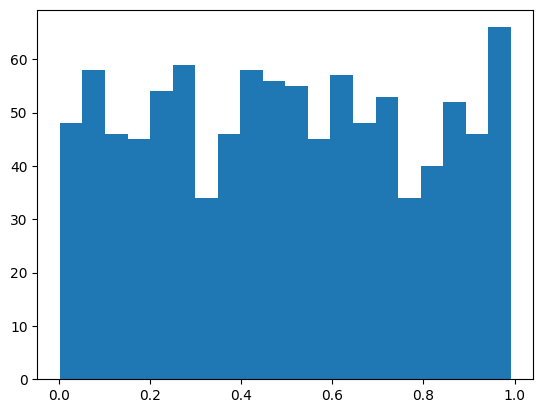

In [192]:
import matplotlib.pyplot as plt
# np.random.seed()

res = []
for i in range(1000):
    n = 30
    a = np.random.randn(n) / len(a)
    b = a + np.random.randn(n) * 1e-4
    # res.append(np.corrcoef(a, b)[0, 1])
    
    
    res.append(wilcoxon(a, b, method='approx').pvalue)

plt.hist(res, bins=20);

In [178]:
a - b

array([ 1.08026684e-03, -2.01501186e-04,  8.25034147e-04,  1.28025860e-03,
       -6.76748456e-04,  6.80664338e-04,  8.05155132e-04,  6.68580567e-04,
        5.45964030e-04,  6.13602997e-04, -1.17387720e-03,  3.94316130e-04,
       -1.90906623e-03, -9.38612277e-05,  2.72926997e-05, -6.76577629e-04,
        6.61738035e-05,  1.82444095e-04, -1.58367109e-03,  8.04082797e-04])

In [74]:
a

array([176.4052346 ,  41.01572084,  99.87379841, 227.08931992,
       190.75579901, -92.72778799, 101.00884175,  -8.13572083,
        -2.32188518,  50.05985019])

In [56]:
wilcoxon(slcA['Anderson-Darling'].tolist(), slcA['Chi-square'].tolist()).pvalue

0.057177370076371574

In [57]:

dist_cm

('Metalog', 'GLopt')

In [58]:
weight_sa

'Anderson-Darling'

In [59]:
distribution, DM, slice(None), weight_sa

('Metalog', 'GLopt', slice(None, None, None), 'Anderson-Darling')

<AxesSubplot:>

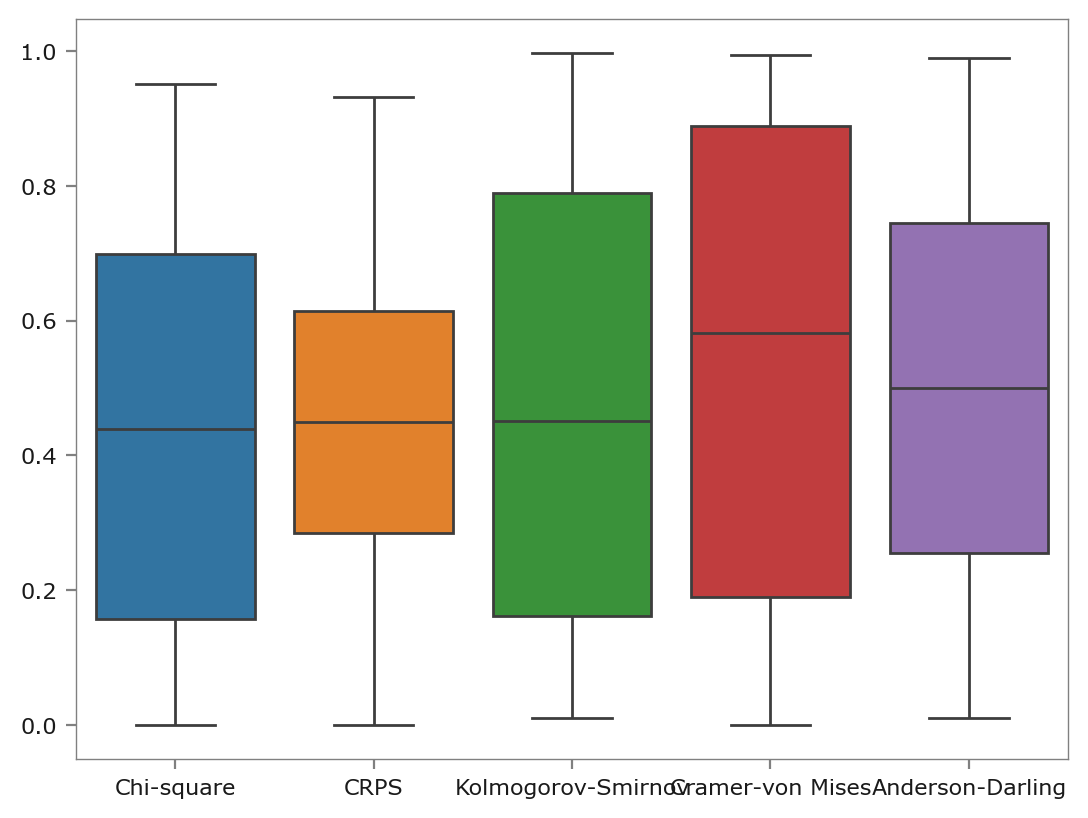

In [61]:
sns.boxplot(slcA)